# Code for simulation analysis

In [1]:
import nibabel as nib
import numpy as np
from model.utils import *
from model.helper import generate_grids, get_basis
import torch
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.pyplot as plt
import model.SIMBA_VI as SIMBA_VI

In [2]:
data = load_pickle('data/simulation/N50_sig_eps2.pickle')

Pickle loaded from data/simulation/N50_sig_eps2.pickle


In [3]:
### load data
true_beta = data['true_eff']
Y = data['sim_data'][0] # image data, use first replication as example
X = data['X'] # covariates
S = data['S'] # spatial location

In [ ]:
### load mask
data_path = 'data/NARPS'
mask_path = f'{data_path}/group_mask.inter.nii.gz'
mask_img = nib.Nifti1Image.from_filename(mask_path)
mask = nib.Nifti1Image.from_filename(mask_path).get_fdata()
slice = mask[:, :, 40]
x, y = np.nonzero(slice)

In [5]:
### choose kernel function with length scale 0.1
ls = 0.3
kernel = Matern(length_scale=ls, nu=1.5)

In [6]:
full_cov = kernel(S,S)
U,lamb_sqrt,_ = np.linalg.svd(full_cov)

In [7]:
cumsum = np.cumsum(lamb_sqrt, axis=0)
total = np.sum(lamb_sqrt)
lower = np.nonzero(cumsum >= 0.8 * total)[0][0]
upper = np.nonzero(cumsum >= 0.98 * total)[0][0]

In [8]:
L_list = np.linspace(lower, upper,num=5, dtype=int)
L_list

array([ 19,  43,  68,  92, 117])

In [9]:
N, V = Y.shape
n_ind = torch.arange(0,N)

### LOOCV-PMSE selecting number of L

In [ ]:
vi_results = []
for L in L_list:
    L_eta = int(0.1*L)
    mse = []
    mae = []
    for i in range(N):
        Y_i = Y[np.where(n_ind != i)]
        X_i = X[np.where(n_ind != i)]
        model = SIMBA_VI.SIMBA_VI(Y=Y_i, X= X_i, grids=S,
                                 kernel = kernel, L = L, L_eta = L_eta, 
                                 verbose=-1, include_intercept=False)
        paras, profile = model.run(verbose=False)

        Y_pred = X[i] @ paras['E_alpha'] + X[i] @ (paras['E_theta_beta'] @ model.basis.t())
        mse.append(((Y_pred - Y[i]) ** 2).mean())
        mae.append((Y_pred - Y[i]).abs().mean())
    vi_results.append({'L': L, 'MSE': np.mean(mse),'MAE':np.mean(mae)})

In [ ]:
vi_results

[{'L': 19, 'MSE': 5.1485, 'MAE': 1.8090008},
 {'L': 43, 'MSE': 5.0992923, 'MAE': 1.8006387},
 {'L': 68, 'MSE': 5.045636, 'MAE': 1.7913275},
 {'L': 92, 'MSE': 5.031346, 'MAE': 1.7889713},
 {'L': 117, 'MSE': 5.0560145, 'MAE': 1.7933054}]

### Fit the full model

In [ ]:
L = 92
L_eta = int(0.1*L)
model = SIMBA_VI.SIMBA_VI(Y=Y_i, X= X_i, grids=S, kernel = kernel, L = L, L_eta = L_eta,  include_intercept=False)
paras, profile = model.run(verbose=True)

iter: 0, ELBO: -3852.976318359375
iter: 200, ELBO: -3567.99462890625
Used iter 216 finished in 0.26 seconds


### Get VI posterior mean and E_s values

In [ ]:
beta_est = paras['E_alpha'][:,None] + paras['E_theta_beta'] @ model.basis.t()

mcmc_alpha = torch.randn(1, 1000, model.J) * paras['Var_alpha'].sqrt() + paras['E_alpha']
mcmc_theta_beta= torch.randn(1, 1000, model.J, L) * paras['Var_theta_beta'].sqrt()[:,None] + paras['E_theta_beta'][None,None,:,:]
voxel_mcmc = mcmc_alpha[:,:,:,None] + mcmc_theta_beta @ model.basis.t()
voxel_mcmc = voxel_mcmc.reshape(-1, model.J, V)

E_s = (((( voxel_mcmc > 0) * 1.0).mean(0)) - 0.5) * 2
select = (E_s.abs() > 0.95) * 1
beta_select = beta_est * select

### Evaluate results

Text(0.5, 1.0, 'Estimate beta_1')

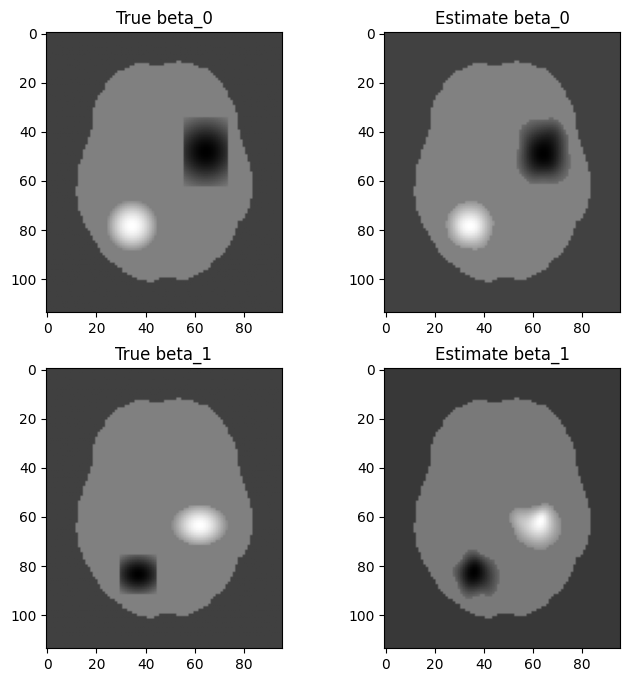

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
template = np.zeros_like(slice)
template[x,y] = true_beta[0]
axes[0, 0].imshow(np.rot90(slice) + np.rot90(template), cmap='gray')
axes[0, 0].set_title("True beta_0")
template[x,y] = beta_select[0]
axes[0, 1].imshow(np.rot90(slice) + np.rot90(template), cmap='gray')
axes[0, 1].set_title("Estimate beta_0")


template[x,y] = true_beta[1]
axes[1, 0].imshow(np.rot90(slice) + np.rot90(template), cmap='gray')
axes[1, 0].set_title("True beta_1")
template[x,y] = beta_select[1]
axes[1, 1].imshow(np.rot90(slice) + np.rot90(template), cmap='gray')
axes[1, 1].set_title("Estimate beta_1")